#### Importing packages

In [1]:
# basic
import pandas as pd
import numpy as np
import datetime as dt
from functools import reduce

# SQL
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


# Stationary Tests
from statsmodels.tsa.stattools import adfuller,kpss

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

NSEED = 42

---

#### Get gold data

In [2]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query -> set your table name here
query = 'SELECT * FROM "03_gold"."fact_electricity_market_germany"'

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql(query, engine)

In [3]:
# Add time variables
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['quarter'] = df['timestamp'].dt.quarter
df['month'] = df['timestamp'].dt.month

In [4]:
# Replace outliers with NAs
df.loc[df['price_eur_mwh'] < -200, 'price_eur_mwh'] = np.nan

# Replace NAs by imputation
df['price_eur_mwh'] = df['price_eur_mwh'].interpolate()

#### Create dataset base for forecast data

In [5]:
# Determine the final date of the original DataFrame
end_date = df['timestamp'].max()

# Create a new DataFrame for the next 72 hours
future_timestamps = pd.date_range(start=end_date + pd.Timedelta(hours=1), periods=72, freq='h')
future_df = pd.DataFrame({'timestamp': future_timestamps})

# Add time variables
future_df['hour'] = future_df['timestamp'].dt.hour
future_df['dayofweek'] = future_df['timestamp'].dt.dayofweek
future_df['quarter'] = future_df['timestamp'].dt.quarter
future_df['month'] = future_df['timestamp'].dt.month

#### Get forecast data

In [6]:
# Define your query
query2 = 'SELECT * FROM "02_silver"."fact_full_weather"'

# Execute the query and load the data into a pandas DataFrame
forecasts = pd.read_sql(query2, engine).sort_values('timestamp')

In [7]:
# Aggregate forecasts across stations
aggregated_forecasts = forecasts.drop(columns=['station_id', 'is_forecast', 'source_table']).groupby('timestamp').mean().reset_index()

# Only use forecast data from after the end of the gold data
aggregated_forecasts = aggregated_forecasts[aggregated_forecasts['timestamp'] > end_date]

In [8]:
# Merge forecasts into the prepared dataframe
predict_df = pd.merge(future_df, aggregated_forecasts, on='timestamp', how='left')
# test_df = test_df.reindex(columns=training_df.columns).drop(columns=['price_eur_mwh'])

---

#### Model training preparations

In [9]:
# Define function to create lagged features (shifted price, rolling mean, standard deviation, maximum and minimum) for the price
def create_lagged_features(df, target_column, lags):
    df_c = df.copy()
    for lag in lags:
        df_c.loc[:, f'{target_column}_{lag}_lag'] = df_c[target_column].shift(lag)
        df_c.loc[:, f'{target_column}_{lag}_mean'] = df_c[target_column].rolling(lag).mean()
        df_c.loc[:, f'{target_column}_{lag}_std'] = df_c[target_column].rolling(lag).std()
        df_c.loc[:, f'{target_column}_{lag}_max'] = df_c[target_column].rolling(lag).max()
        df_c.loc[:, f'{target_column}_{lag}_min'] = df_c[target_column].rolling(lag).min()
    df_c.dropna(inplace=True)
    return df_c

In [10]:
# Set price as target for lagging function
target_column = 'price_eur_mwh'

# Define the hour intervals for the lags
lags = [24, 48, 72]

In [11]:
# Only use features that we currently have future data for 
base_df_vars = ['timestamp','price_eur_mwh' ,'temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m',
            'direct_radiation', 'diffuse_radiation', 'sunshine_duration', 'hour', 'dayofweek', 'quarter', 'month']
base_df = df[base_df_vars]

In [12]:
# Create training data including weather and lagged features

df_train = create_lagged_features(base_df, target_column, lags)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50341 entries, 72 to 50412
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   timestamp              50341 non-null  datetime64[ns, UTC]
 1   price_eur_mwh          50341 non-null  float64            
 2   temperature_2m         50341 non-null  float64            
 3   relative_humidity_2m   50341 non-null  float64            
 4   apparent_temperature   50341 non-null  float64            
 5   precipitation          50341 non-null  float64            
 6   cloud_cover            50341 non-null  float64            
 7   wind_speed_10m         50341 non-null  float64            
 8   wind_direction_10m     50341 non-null  float64            
 9   direct_radiation       50341 non-null  float64            
 10  diffuse_radiation      50341 non-null  float64            
 11  sunshine_duration      50341 non-null  float64            

In [13]:
# Define X and y
X = df_train.drop(columns=['timestamp', 'price_eur_mwh'])
y = df_train['price_eur_mwh']

---

#### Training the model

In [14]:
model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor()

---

#### Preparations for predictions on unseen data

In [15]:
# Create new dataframe from slice of df_train as a starting point for lagged values (optional, you can use simply the training data, too)
df_start = df_train[-75:]

In [16]:
# Set weather predictor variables (timestamp remains for future merging)
preds = ['timestamp', 'temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m',
            'direct_radiation', 'diffuse_radiation', 'sunshine_duration', 'hour', 'dayofweek', 'quarter', 'month']

---

#### Make predictions for unseen data

In [17]:
# Define function to create lagged features that will be used as predictors (timestamp shifted to merge with weather predictors)
def create_new_predictors(df, target_column, lags):
    df_c = df.copy()
    for lag in lags:
        df_c.loc[:, f'{target_column}_{lag}_lag'] = df_c[target_column].shift(lag)
        df_c.loc[:, f'{target_column}_{lag}_mean'] = df_c[target_column].rolling(lag).mean()
        df_c.loc[:, f'{target_column}_{lag}_std'] = df_c[target_column].rolling(lag).std()
        df_c.loc[:, f'{target_column}_{lag}_max'] = df_c[target_column].rolling(lag).max()
        df_c.loc[:, f'{target_column}_{lag}_min'] = df_c[target_column].rolling(lag).min()
    df_c.loc[df_c.index[-1], 'timestamp'] = df_c['timestamp'].iloc[-1] + pd.Timedelta(hours=1)
    return df_c[-1:]

In [18]:
# Create prediction function
def predict_72h(start_df, future_df, predictor_vars, target_column, datetime, model, lags):
    """
    Predicts a target variable hourly into the future for 72 hours.

    Parameters:
    - start_df: Dataframe, the data that is needed to create the lagged features (can be the training data or a slice of it)
    - future_df: Dataframe, the same features as in the start_df minus the target variable, with values for the next 72 hours
    - predictor_vars: list, the variables in the dataframe that are predictors 
    - target_column: string, the name of the variable that is supposed to be predicted
    - datetime: string, the name of the datetime variable 
    - model: a pretrained model that is used for the predictions
    - lags: list, the values for the hours of lags

    Returns:
    - predictions: list, 72 values that represent the predictions for the future values of the target variable
    """
    
    # Create empty predictions list
    predictions = []

    # Make copies of dataframes:
    start_df_c = start_df
    future_df_c = future_df

    # Iniate loop
    for i in range(0, 72):

        # Create dataframe with weather predictor for the unseen value
        pred1 = future_df_c[predictor_vars][i:i+1]

        # Create dataframe with lagged predictors for first unseen value
        pred2 = create_new_predictors(start_df_c, target_column=target_column, lags=lags)
        # Combine predictor dataframes into final predictor
        cols = [col for col in pred2.columns if col not in pred1.columns or col == datetime]
        pred2_f = pred2[cols]
        predictors = pd.merge(pred1, pred2_f, on=datetime, how='left')

        # Make prediction
        y = model.predict(predictors.drop(columns=[target_column, datetime]))

        # Add prediction to prediction list
        predictions.append(y)

        # Combine prediction with predictors to new dataframe with same features as start_df
        pred1[target_column] = y
        cols2 = pred1.columns.tolist()
        new_cols_order = cols2[:1] + [target_column] + cols2[1:-1] 
        appendage = pred1[new_cols_order]
        
        # Add new row to dataframe to be ready to start again
        start_df_c = pd.concat([start_df_c, appendage], axis=0, ignore_index=True)

    return predictions  
    

In [19]:
price_pred = predict_72h(df_start, predict_df, preds, 'price_eur_mwh', 'timestamp', model, lags)

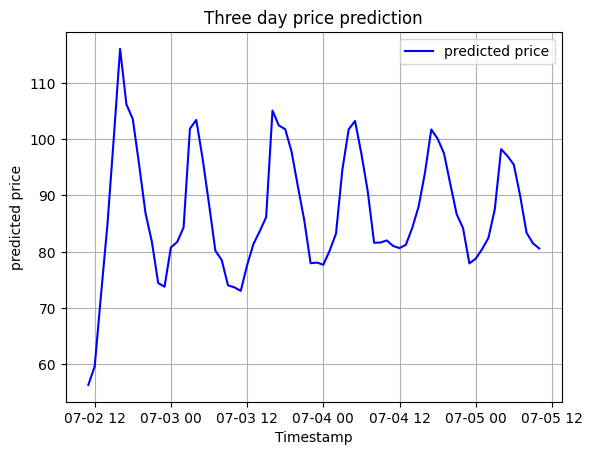

In [20]:
plt.plot(predict_df['timestamp'], price_pred, label='predicted price', color='blue')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('predicted price')
plt.title('Three day price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

In [21]:
# Get feature importances
importances = model.feature_importances_

# Get the indices of features in descending order of importance
indices = np.argsort(importances)[::-1]

# Get the column names from X_train
feature_names = X.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
1. feature price_eur_mwh_24_mean: 0.23677792004100384
2. feature price_eur_mwh_24_max: 0.17077343732737169
3. feature price_eur_mwh_48_mean: 0.10562090707065698
4. feature price_eur_mwh_24_lag: 0.10036311879949397
5. feature price_eur_mwh_24_min: 0.08980321788633158
6. feature price_eur_mwh_72_mean: 0.0729880570688292
7. feature price_eur_mwh_48_max: 0.057102650023855624
8. feature price_eur_mwh_72_max: 0.04618715251900877
9. feature price_eur_mwh_48_lag: 0.02071171162155561
10. feature price_eur_mwh_72_lag: 0.014412078947300892
11. feature dayofweek: 0.013851949090744343
12. feature hour: 0.010763876394394082
13. feature wind_speed_10m: 0.007969804065018345
14. feature price_eur_mwh_48_min: 0.005536333276930178
15. feature price_eur_mwh_24_std: 0.005407360476658254
16. feature price_eur_mwh_48_std: 0.005268719835706764
17. feature price_eur_mwh_72_std: 0.003950411946623562
18. feature direct_radiation: 0.0034545744906917314
19. feature sunshine_duration: 0.00338828196

---

#### Compare against real prices

In [30]:
# Get real prices to compare

# Define your query
query3 = 'SELECT * FROM "02_silver"."fact_day_ahead_prices_germany"'

# Execute the query and load the data into a pandas DataFrame
prices = pd.read_sql(query3, engine).sort_values('timestamp')

# Only prices and timestamp
just_prices = prices[['timestamp', 'de_lu']]

# Merge with the relevant 72h dataframe
merged = pd.merge(future_df, just_prices, 'inner', 'timestamp')

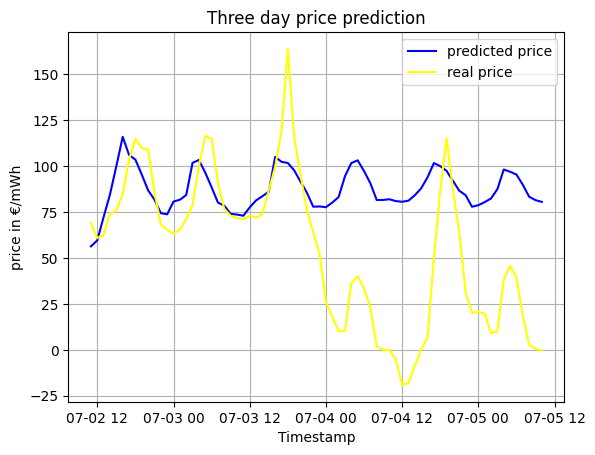

In [31]:
plt.plot(predict_df['timestamp'], price_pred, label='predicted price', color='blue')
plt.plot(predict_df['timestamp'], merged['de_lu'], label='real price', color='yellow')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('price in €/mWh')
plt.title('Three day price prediction')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()